In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math
from scipy import signal


# Data Stream Class
Class Data Stream is to hold an activities data.
It parses a csv.
It rotates, interpolates, and integrates data.

In [2]:
class Data_Stream:
    gps = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    rot_vec = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    mag = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    gyro = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    acc_with_grav = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    
    acc_DRC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    vel_DRC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    dis_DRC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    
    acc_ERC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    vel_ERC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    dis_ERC = np.asmatrix([0.0, 0.0, 0.0, 0.0])
    
    frequency = 0.0
    time_period = 0.0
    
    var_codes = {1.0 : gps, 82.0 : acc_DRC, 84.0 : rot_vec}
    
    def __init__(self, filename, invert=False):
        self.var_codes = {1.0 : [], 82.0 : [], 84.0 : [], 3.0 : [], 4.0 : [], 5.0 : []}
        
        ##Parse file
        f=open(filename, "r")
        start_time = False
        for line in f:
            line = line.split(',')
            if(start_time == False):
                start_time = float(line[0])
            self.process_csv_line(start_time, line)
        self.var_codes[1.0] = np.delete(self.var_codes.get(1.0), (0), axis=0) #GPS cant be (0 0 0 0) at init
        for key, value in self.var_codes.items():
            self.var_codes[key] = np.concatenate(value)
        print("Parsed File")
        
        ##Convert longitude and latitutde of GPS sensor to meters
        self.var_codes[1.0] = self.convert_longlat_to_dis(self.var_codes.get(1.0))
        
        ##Interpolate rotation and acceleration so that they occur at the same time step
        new_time = self.var_codes.get(3.0)[:, 0] # Set timesteps to be that of the acceleration, as it has most readings
        for key, value in self.var_codes.items():
#             if(key != 1.0):
            irreg_var = value
            reg_varX = np.asmatrix(np.interp(new_time, np.ravel(irreg_var[:,0]), np.ravel(irreg_var[:,1])))
            reg_varY = np.asmatrix(np.interp(new_time, np.ravel(irreg_var[:,0]), np.ravel(irreg_var[:,2])))
            reg_varZ = np.asmatrix(np.interp(new_time, np.ravel(irreg_var[:,0]), np.ravel(irreg_var[:,3])))
            self.var_codes[key] = np.concatenate((new_time, reg_varX, reg_varY, reg_varZ), axis=1)
        print("Interpolated Samples")
        

        
        ##Set class members to matrices read from csv
        self.acc_DRC = self.var_codes.get(82.0)
        self.rot_vec = self.var_codes.get(84.0)
        self.gyro = self.var_codes.get(4.0)
        self.mag = self.var_codes.get(5.0)
        self.acc_with_grav = self.var_codes.get(3.0)
        self.gps = self.var_codes.get(1.0)
        
        # If device axis is wrong, invert data
        self.invert_acceleration()
        
        ##Use rotation vectors to achieve acceleration in ERC        
        self.acc_ERC = self.rotate_acceleration(self.rot_vec, self.acc_DRC)
        print("Rotated Acceleration")
        
        ##Integrate each acceleration to calculate velocity and displacement
        self.integrate_variables()
        print("Integrated Acceleration")
        
        #Calculate Acc_DRC frequency
        self.time_period = np.mean(np.diff(self.acc_ERC[:, 0].T))
        self.frequency = 1/self.time_period
        
    def invert_acceleration(self):
        for i in self.acc_DRC:
            i[0, 1] *= -1
            i[0, 2] *= -1
    
    def process_csv_line(self, start_time, line):
        i = 1
        while(i < len(line)):
            if(float(line[i]) in self.var_codes):
                self.var_codes[float(line[i])].append(
                    np.asmatrix([float(line[0])-start_time, float(line[i+1]), float(line[i+2]), float(line[i+3])]))
            if(float(line[i]) == 8.0):
                i+=2
            else :
                i+=4
                
    def integrate_variable(self, var):
        return np.concatenate((self.acc_DRC[:,0], integrate.cumtrapz(var[:,1:4], initial=0, axis=0)), axis=1)
    def integrate_variables(self):
        self.vel_DRC = self.integrate_variable(self.acc_DRC)
        self.dis_DRC = self.integrate_variable(self.vel_DRC)
        
        self.vel_ERC = self.integrate_variable(self.acc_ERC)
        self.dis_ERC = self.integrate_variable(self.vel_ERC)
    def rotate_acceleration(self, rot_vectors, acc_vectors):
        acc_ERC = acc_vectors[:, 0]
        acc_ERC_list=[]
        for i in range(rot_vectors[:, 0].shape[0]):
            rot_matrix_inv = self.get_rotation_matrix(rot_vectors[i, 1:4]) #Orthogonal so transpose is inverse
            acc_ERC_list.append(np.matmul(rot_matrix_inv, acc_vectors[i, 1:4].T).T)        

        return np.concatenate((acc_ERC, np.concatenate(acc_ERC_list)), axis=1)
    
    def get_rotation_matrix(self, rot_vec):
        qx = rot_vec[0, 0]
        qy = rot_vec[0, 1]
        qz = rot_vec[0, 2]
        qw = 1 - qx**2 - qy**2 - qz**2
#         qw = math.sqrt(max(qw, 0))

        rot_matrix = np.asmatrix([1-2*qy**2-2*qz**2, 2*qx*qy-2*qz*qw, 2*qx*qz+2*qy*qw])
        rot_matrix = np.concatenate((rot_matrix, np.asmatrix([2*qx*qy+2*qz*qw,  1-2*qx**2-2*qz**2, 2*qy*qz-2*qx*qw])),
                                    axis=0)
        rot_matrix = np.concatenate((rot_matrix, np.asmatrix([2*qx*qz-2*qy*qw, 2*qy*qz+2*qx*qw, 1-2*qx**2-2*qy**2])),
                                    axis=0)
        return rot_matrix
    
    def convert_longlat_to_dis(self, gps):
        dis_list = [np.asmatrix([gps[0, 0], 0.0, 0.0, gps[0, 3]])]
        start_gps = gps[0]
        for i in range(1, gps.shape[0]-1): ## SWAP X and Y as in wrong order from stream
            dis_list.append(np.asmatrix([
                                gps[i, 0],
                                self.get_arc_len(start_gps[2], gps[i, 2]),
                                self.get_arc_len(start_gps[1], gps[i, 1]),
                                gps[i, 3]]))
        return np.concatenate(dis_list)
    
    def get_arc_len(self, deg1, deg2):
        delta_theta = deg2 - deg1
        delta_theta = ((delta_theta+180)%360)-180
        earth_R = 6378100
        return 2.0*math.pi*earth_R*delta_theta/360.0
        
        
        
        

In [9]:
data = Data_Stream("Data/data5.csv")
print(data.acc_DRC.shape)

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
(4760, 4)


## Plot each variable on a graph

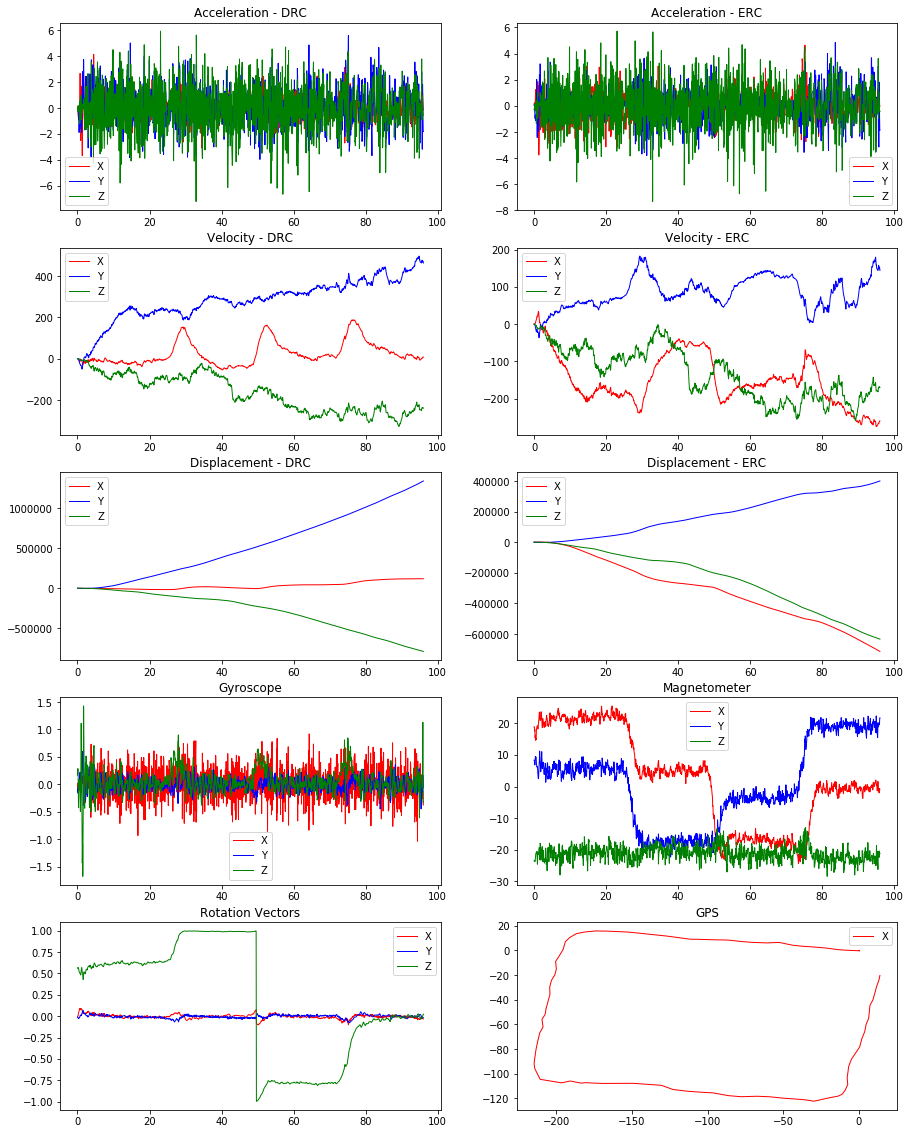

In [10]:
def plot_data(data):
    # Graph the variables.
    plt.figure(figsize=(15, 20))
    ax=plt.subplot(521)
    plt.plot(data.acc_DRC[:, 0], data.acc_DRC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.acc_DRC[:, 0], data.acc_DRC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.acc_DRC[:, 0], data.acc_DRC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Acceleration - DRC")
    ax.legend()

    ax=plt.subplot(522)
    plt.plot(data.acc_ERC[:, 0], data.acc_ERC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.acc_ERC[:, 0], data.acc_ERC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.acc_ERC[:, 0], data.acc_ERC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Acceleration - ERC")
    ax.legend()

    ax=plt.subplot(523)
    plt.plot(data.vel_DRC[:, 0], data.vel_DRC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.vel_DRC[:, 0], data.vel_DRC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.vel_DRC[:, 0], data.vel_DRC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Velocity - DRC")
    ax.legend()

    ax=plt.subplot(524)
    plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Velocity - ERC")
    ax.legend()

    ax=plt.subplot(525)
    plt.plot(data.dis_DRC[:, 0], data.dis_DRC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.dis_DRC[:, 0], data.dis_DRC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.dis_DRC[:, 0], data.dis_DRC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Displacement - DRC")
    ax.legend()

    ax=plt.subplot(526)
    plt.plot(data.dis_ERC[:, 0], data.dis_ERC[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.dis_ERC[:, 0], data.dis_ERC[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.dis_ERC[:, 0], data.dis_ERC[:, 3], 'g-', lw=1, label='Z')
    plt.title("Displacement - ERC")
    ax.legend()

    ax=plt.subplot(527)
    plt.plot(data.gyro[:, 0], data.gyro[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.gyro[:, 0], data.gyro[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.gyro[:, 0], data.gyro[:, 3], 'g-', lw=1, label='Z')
    plt.title("Gyroscope")
    ax.legend()

    ax=plt.subplot(528)
    plt.plot(data.mag[:, 0], data.mag[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.mag[:, 0], data.mag[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.mag[:, 0], data.mag[:, 3], 'g-', lw=1, label='Z')
    plt.title("Magnetometer")
    ax.legend()

    ax=plt.subplot(529)
    plt.plot(data.rot_vec[:, 0], data.rot_vec[:, 1], 'r-', lw=1, label='X')
    plt.plot(data.rot_vec[:, 0], data.rot_vec[:, 2], 'b-', lw=1, label='Y')
    plt.plot(data.rot_vec[:, 0], data.rot_vec[:, 3], 'g-', lw=1, label='Z')
    plt.title("Rotation Vectors") ##Proof that values are reversed, should be -9.8 its 9.8
    ax.legend()

    ax=plt.subplot(5, 2, 10)
    plt.plot(data.gps[:, 1], data.gps[:, 2], 'r-', lw=1, label='X')
    plt.title("GPS") ##Proof that values are reversed, should be -9.8 its 9.8
    ax.legend()
    
plot_data(data)

## Perform butterworth low pass filtering, re integrate data and plot
Frequency cutoff value is just an estimate

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration


/home/hw16471/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


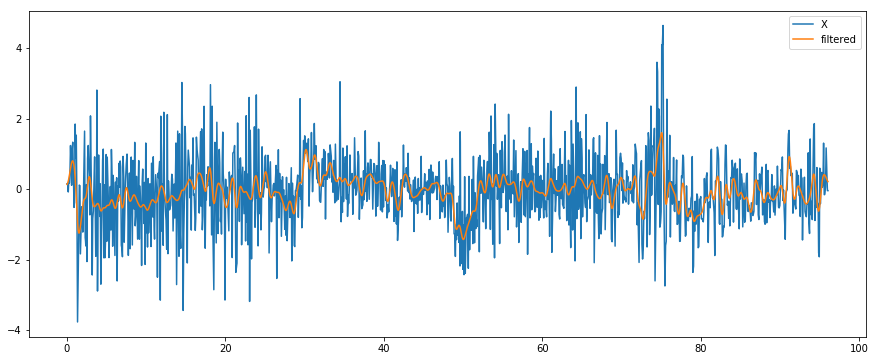

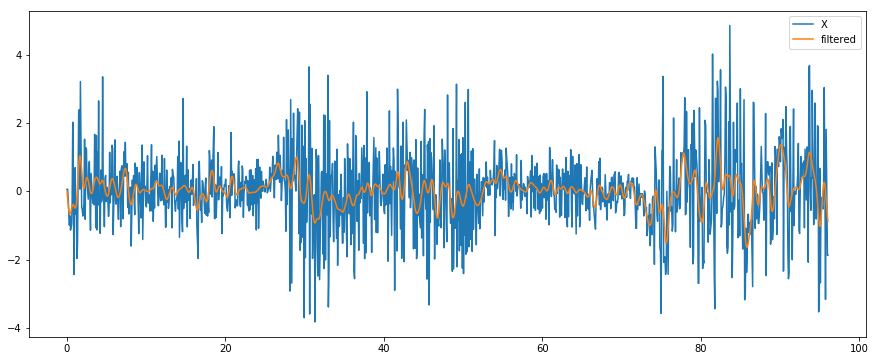

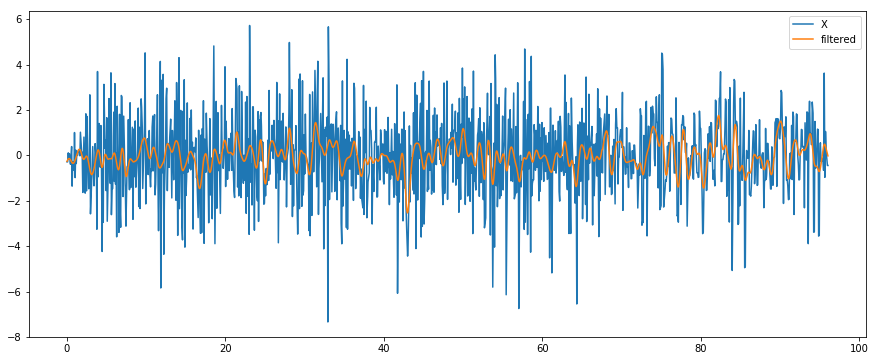

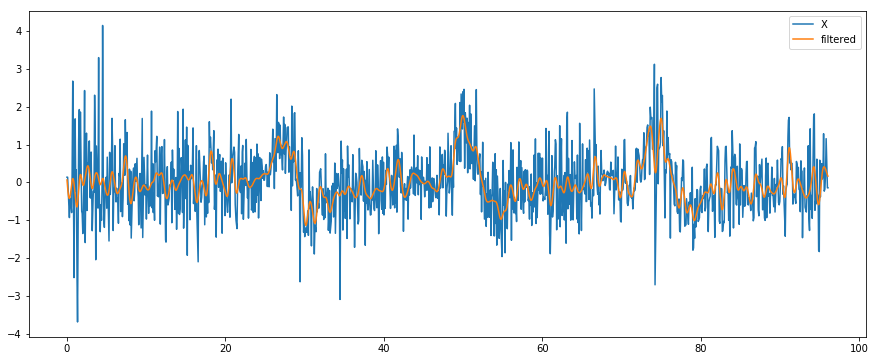

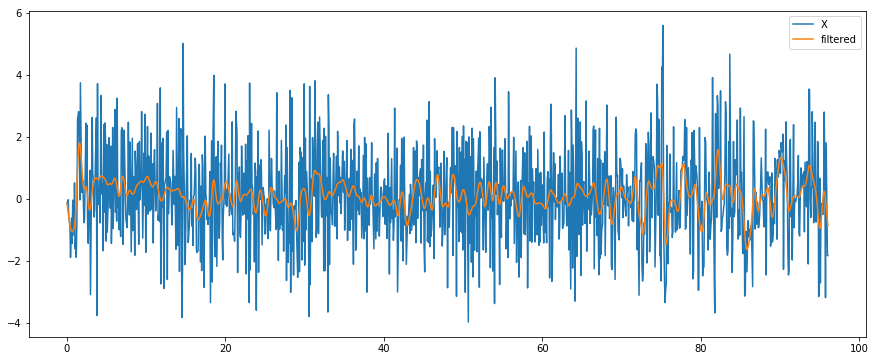

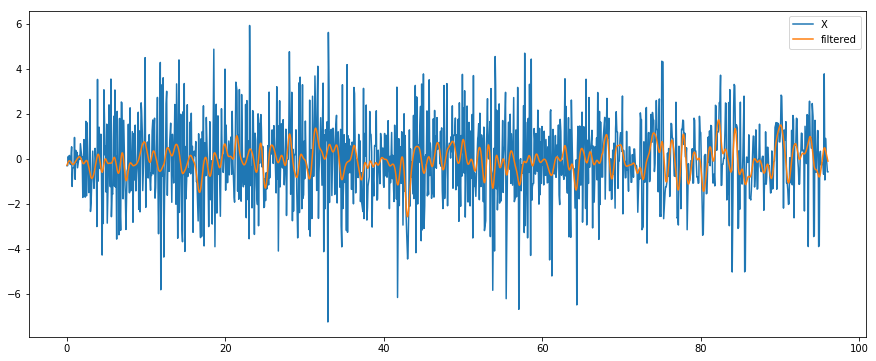

In [19]:
data = Data_Stream("Data/data5.csv")
def filter_acc(times, acc, T, fs, plot=True):
    fs = data.frequency  # Sampling frequency
    fc = 1  # Cut-off frequency of the filter
    w = fc / (fs / 2) # Normalize the frequency

    b, a = signal.butter(3, w, 'low') ##W is between 1 and 0, 1 is a perfect reconstruction, ie shannon nyquist

    output = signal.filtfilt(b, a, acc.T)
    if(plot):
        plt.figure(figsize=(15, 6))
        ax=plt.subplot(111)
        plt.plot(times, acc, label='X')
        plt.plot(times, output.T, label='filtered')
        plt.legend()
        plt.show()
    return output.T


data.acc_ERC[:, 1] = filter_acc(data.acc_ERC[:, 0], data.acc_ERC[:, 1], data.time_period, data.frequency)
data.acc_ERC[:, 2] = filter_acc(data.acc_ERC[:, 0], data.acc_ERC[:, 2], data.time_period, data.frequency)
data.acc_ERC[:, 3] = filter_acc(data.acc_ERC[:, 0], data.acc_ERC[:, 3], data.time_period, data.frequency)

data.acc_DRC[:, 1] = filter_acc(data.acc_DRC[:, 0], data.acc_DRC[:, 1], data.time_period, data.frequency)
data.acc_DRC[:, 2] = filter_acc(data.acc_DRC[:, 0], data.acc_DRC[:, 2], data.time_period, data.frequency)
data.acc_DRC[:, 3] = filter_acc(data.acc_DRC[:, 0], data.acc_DRC[:, 3], data.time_period, data.frequency)



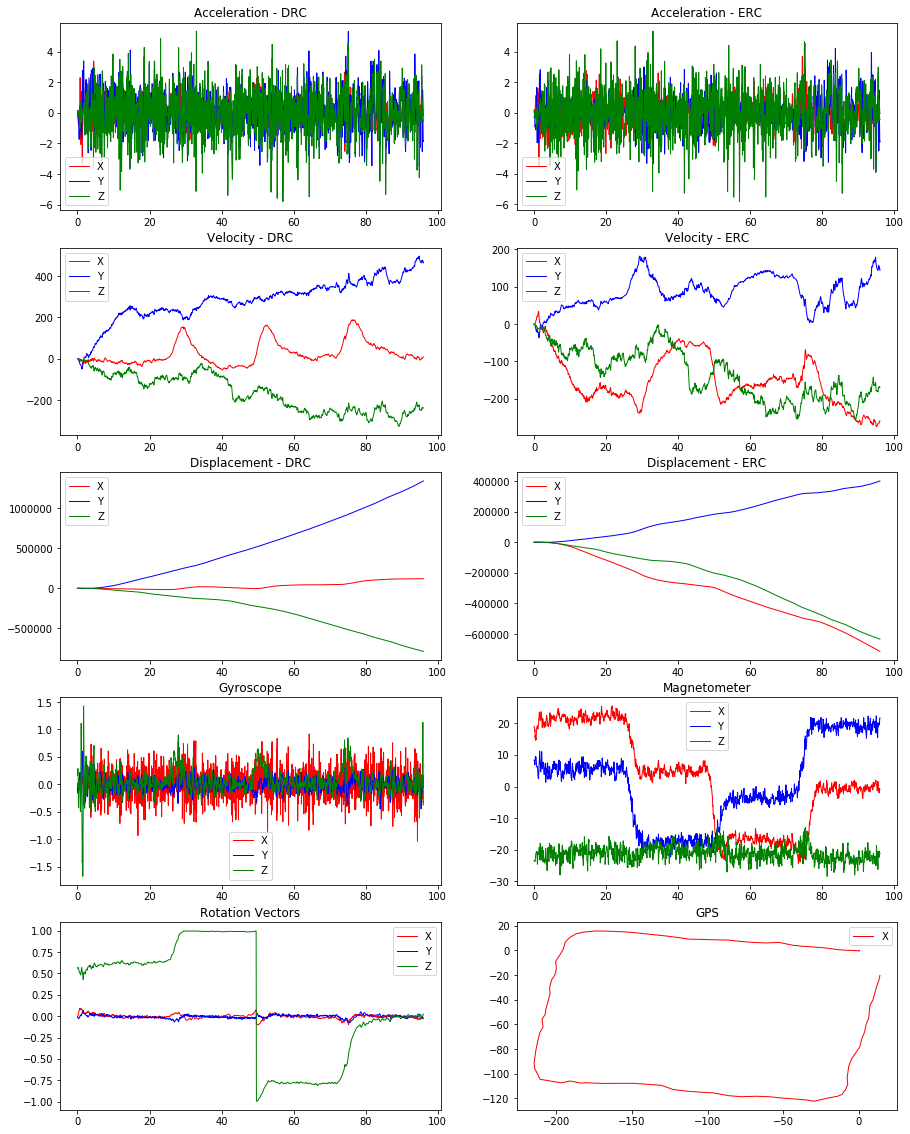

In [14]:
data.integrate_variables()
plot_data(data)


In [ ]:
def getQ(acc_stddev, dt):
    vel_stddev = acc_stddev*dt
    dis_stddev = 0.5*acc_stddev*dt**2
    Q = (dis_stddev**2)*np.identity(4)
    Q[2, 2] = vel_stddev**2
    Q[3, 3] = vel_stddev**2
    Q[0, 2] = dis_stddev*vel_stddev
    Q[1, 3] = dis_stddev*vel_stddev
    return Q

def getFkBk(Fk, Bk, dt):
    Fk[0, 2] = dt
    Fk[1, 3] = dt
    Bk[0, 0] = 0.5*dt**2
    Bk[1, 1] = 0.5*dt**2
    Bk[2, 0] = dt
    Bk[3, 1] = dt
    return Fk, Bk

def kalman_predict(dt, Fk, Bk, xk, uk, Pk, acc_stddev):
    Q = getQ(acc_stddev, dt)
    Fk, Bk = getFkBk(Fk, Bk, dt)
    xk = np.matmul(Fk, xk) + np.matmul(Bk, uk)
    Pk = np.matmul(np.matmul(Fk, Pks[-1]), Fk.T) + Q
    return xk, Pk, Fk, Bk

def kalman_gain(Pk, H, R):
    PkHT = np.matmul(Pk, H.T)
    K = np.matmul(PkHT, np.linalg.inv(np.matmul(H, PkHT)+R))
    return K

def kalman_update_state(xk, zk, K, H):
    Hxk = np.matmul(H, xk)
    zk = np.concatenate((zk, np.asmatrix([0])))
    zk = np.concatenate((zk, np.asmatrix([0])))
    return xk+np.matmul(K, zk-Hxk )

def kalman_update_uncertainty(Pk, K, H):
    return Pk - np.matmul(K, np.matmul(H, Pk))
    

In [60]:
data = Data_Stream("Data/data5.csv")

## Assume that the initial state is position (0, 0) and velocity (0, 0)
x0 = np.asmatrix([0, 0, 0, 0]).T
xks = [x0]
u0 = data.acc_ERC[0, 1:3].T
uks = [u0]
Fk = np.asmatrix(np.identity(4))
Bk = np.zeros((4, 2))

acc_stddev = 0.2

P0 = np.zeros((4, 4))
Pks = [P0]

H = np.identity(4)
H[2, 2] = 0.0
H[3, 3] = 0.0
gps_var = 15.2
R = gps_var*np.identity(4)


for i in range(1, data.acc_DRC.shape[0]):
    dt = data.acc_DRC[i, 0] - data.acc_DRC[i-1, 0]
    xk, Pk, Fk, Bk = kalman_predict(dt, Fk, Bk, xks[-1], uks[-1], Pks[-1], acc_stddev)
    xks.append(xk)
    uks.append(data.acc_ERC[i, 1:3].T)
    Pks.append(Pk)
    zk = data.gps[i, 1:3].T
    
    K = kalman_gain(Pks[-1], H, R)
    xks[-1] = kalman_update_state(xk, zk, K, H)
    Pks[-1] = kalman_update_uncertainty(Pks[-1], K, H)
       
    
xks = [xk.T for xk in xks]
xks = np.concatenate(xks)

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration


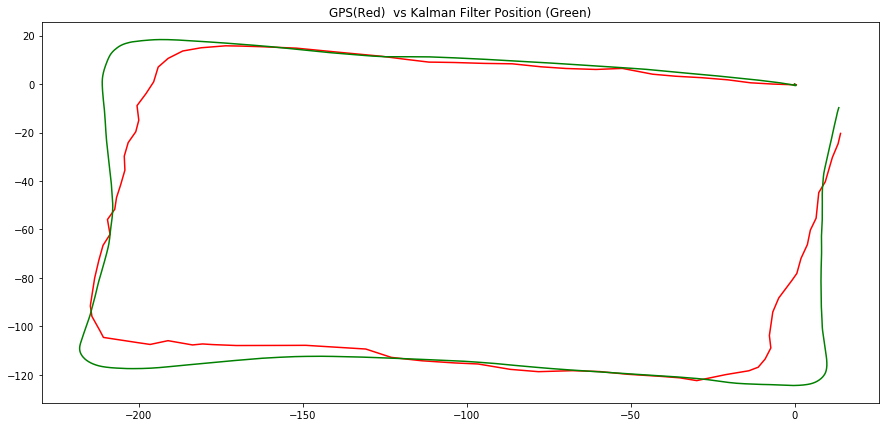

In [61]:
plt.figure(figsize=(15, 7))
ax=plt.subplot(111)
plt.title("GPS(Red)  vs Kalman Filter Position (Green)")
plt.plot(data.gps[:, 1], data.gps[:, 2], 'r-')
plt.plot(xks[:, 0], xks[:, 1], 'g-')

Text(0.5,1,'Velocity Y (Integration of Uncorrected Acceleration)')

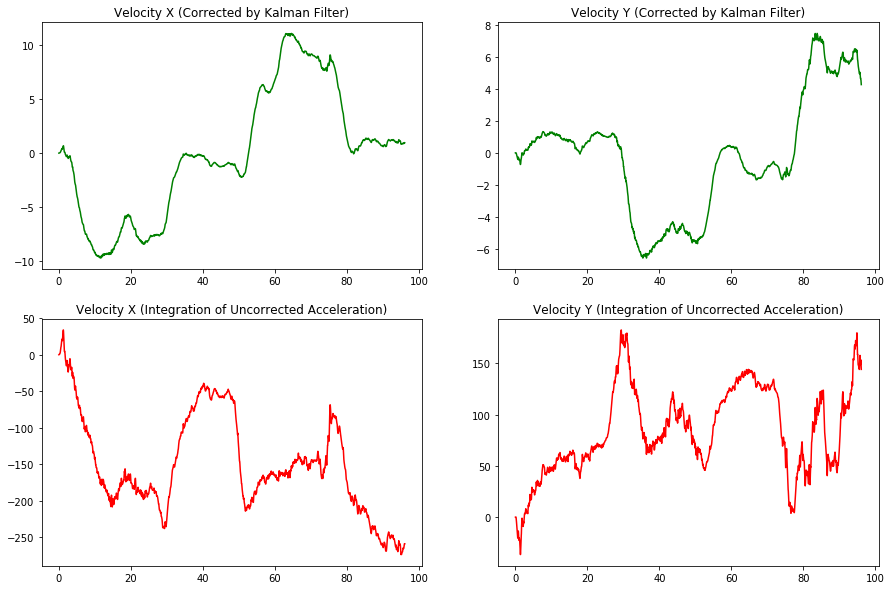

In [59]:
plt.figure(figsize=(15, 10))
ax=plt.subplot(221)
# plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 1], 'r-')
plt.plot(data.vel_ERC[:, 0], xks[:, 2], 'g-')
plt.title("Velocity X (Corrected by Kalman Filter)")


ax=plt.subplot(222)
# plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 2], 'r-')
plt.plot(data.vel_ERC[:, 0], xks[:, 3], 'g-')
plt.title("Velocity Y (Corrected by Kalman Filter)")


ax=plt.subplot(223)
plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 1], 'r-', )
plt.title("Velocity X (Integration of Uncorrected Acceleration)")


ax=plt.subplot(224)
plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 2], 'r-')
plt.title("Velocity Y (Integration of Uncorrected Acceleration)")
